In [82]:
##Libraries
import numpy as np
import matplotlib.pyplot as plt

In [83]:
# Time setup
total_years = 20
dt = 1/12 # monthly time step
time = np.arange(0, total_years, dt)
n = len(time)

# Initialize arrays

Below_Baseline_Stock = np.zeros(n)
Baseline_Stock = np.zeros(n)
Efficient_Stock = np.zeros(n)
Cumulative_adopters = np.zeros(n)

Efficient_nc = np.zeros(n)
Baseline_nc = np.zeros(n)


Retirement_Flow_arr = np.zeros(n)
Below_Baseline_Adoption_Flow_arr = np.zeros(n)
Baseline_Adoption_Flow_arr = np.zeros(n)
Efficient_Adoption_Flow_arr = np.zeros(n)
Total_Adoption_Flow_arr = np.zeros(n)

out_Below_Baseline_Adoption_Flow_arr = np.zeros(n)
out_Baseline_Adoption_Flow_arr = np.zeros(n)
out_Efficient_Adoption_Flow_arr = np.zeros(n)

Total_Below_Baseline_Adoption_Flow_arr = np.zeros(n)
Total_Baseline_Adoption_Flow_arr = np.zeros(n)
Total_Efficient_Adoption_Flow_arr = np.zeros(n)

bass_share_arr = np.zeros(n)
bass_value_arr = np.zeros(n)

In [84]:
""" Could do this from individual pieces to total market size or market size to individual pieces"""
# Initialize m as an array
m = np.zeros(n)
m[0] = 1000  # initial market size
building_count_to_condition_count_factor = 1 # effects the total competition group size not the individual pieces # this adjustment factor will not change over time 
#to be a matrix based on Competition group and building type row furnace and column single family home 
# look up value needed for computation


# Initial stocks
initial_below_baseline = m[0]  * 0.3  # 30% below baseline
initial_baseline = m[0]  * 0.5  # 50% baseline
initial_efficient = m[0] * 0.2  # 20% efficient at start

retirement_rate = 0.05    # 5% of total equipment retires per year

initial_adopters = initial_efficient  # Initial adopters are those with efficient equipment
#total_stock = initial_below_baseline + initial_baseline + initial_efficient
# Set initial values

Below_Baseline_Stock[0] = initial_below_baseline
Baseline_Stock[0] = initial_baseline
Efficient_Stock[0] = initial_efficient
Cumulative_adopters[0] = initial_adopters

In [85]:
#New Construction module #we can make this an array that changes with time
nc = 100

# Initial stocks for NC
initial_below_baseline_nc = nc * 0.0  # 0% below baseline
initial_baseline_nc = nc * 0.5  # 50% baseline
initial_efficient_nc = nc* 0.5  # 50% efficient at start

#currently static with time so dont need to be in a list but will need to be in the future?
Efficient_nc[0] = initial_efficient_nc
Baseline_nc[0] = initial_baseline_nc

In [86]:
# Bass diffusion and retirement parameters
par = {
    "p": 0.03,                 # innovation coefficient
    "q": 0.38,                 # imitation coefficient
}

In [87]:
def bass_diff_eq(
    Below_Baseline, Baseline, Efficient, Cumulative_adopters, par, m, retirement_rate,
    nc, Baseline_nc, Efficient_nc
):
    p = par["p"]
    q = par["q"]

    # Add new construction to total market size
    #total_m =  Efficient + Baseline + Below_Baseline
    total_m =  m + nc  # update total market size with new construction

    bass_value = (p + q * (Cumulative_adopters / total_m)) * (total_m - Cumulative_adopters)
    bass_share = np.clip((bass_value + Cumulative_adopters)/total_m, 0.0, 1.0)

    # inflows 
    total_stock = Efficient + Baseline + Below_Baseline
    Retirement_Flow = total_stock * retirement_rate
    #Retirement_Flow = total_m * retirement_rate
    Efficient_Adoption_Flow = Retirement_Flow * bass_share + Efficient_nc
    Remaining_Flow = Retirement_Flow - (Retirement_Flow * bass_share)
    Baseline_Adoption_Flow = Remaining_Flow + Baseline_nc
    Below_Baseline_Adoption_Flow = 0.0


    # Proportional outflows
    out_Efficient_Adoption_Flow = -Retirement_Flow * (Efficient / total_stock) if total_stock > 0 else 0
    out_Baseline_Adoption_Flow = -Retirement_Flow * (Baseline / total_stock) if total_stock > 0 else 0
    out_Below_Baseline_Adoption_Flow = -Retirement_Flow * (Below_Baseline / total_stock) if total_stock > 0 else 0
    # # outflows
    # out_Efficient_Adoption_Flow = - (Efficient * retirement_rate) 
    # out_Baseline_Adoption_Flow = - (Baseline * retirement_rate)
    # out_Below_Baseline_Adoption_Flow = - (Below_Baseline * retirement_rate)

    # Euler differentials
    dEfficient_dt = Efficient_Adoption_Flow - (Efficient * retirement_rate)
    dBaseline_dt = Baseline_Adoption_Flow - (Baseline * retirement_rate)
    dBelow_Baseline_dt = Below_Baseline_Adoption_Flow - (Below_Baseline * retirement_rate)
    dadopters_dt = Efficient_Adoption_Flow - (Efficient * retirement_rate)
    m_dt = nc  # change in market size due to new construction
    
    flows = {
        "Retirement": Retirement_Flow,
        "Efficient_Adoption": Efficient_Adoption_Flow,
        "Baseline_Adoption": Baseline_Adoption_Flow,
        "Below_Baseline_Adoption": Below_Baseline_Adoption_Flow,
        "Total_Adoption_Flow": Retirement_Flow,
        "out_Efficient_Adoption": out_Efficient_Adoption_Flow,
        "out_Baseline_Adoption": out_Baseline_Adoption_Flow,
        "out_Below_Baseline_Adoption": out_Below_Baseline_Adoption_Flow,
        "Total_Efficient_Adoption": dEfficient_dt,
        "Total_Baseline_Adoption": dBaseline_dt,
        "Total_Below_Baseline_Adoption": dBelow_Baseline_dt,
        "bass_value": bass_value,
        "bass_share": bass_share,
        "Cumulative_adopters": Cumulative_adopters
    }

    return dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, dadopters_dt, m_dt, flows

In [88]:
for t in range(1, n):
    dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, dadopters_dt, m_dt, flows = bass_diff_eq(
        Below_Baseline_Stock[t-1],
        Baseline_Stock[t-1],
        Efficient_Stock[t-1],
        Cumulative_adopters[t-1],
        par,
        m[t-1],
        retirement_rate,
        nc=nc,
        Baseline_nc=Baseline_nc[t-1],
        Efficient_nc=Efficient_nc[t-1]
    )

    # Euler integration
    Below_Baseline_Stock[t] = Below_Baseline_Stock[t-1] + dBelow_Baseline_dt * dt
    Baseline_Stock[t] = Baseline_Stock[t-1] + (dBaseline_dt * dt) + (Baseline_nc[t-1] * dt)  # Add new construction
    Efficient_Stock[t] = Efficient_Stock[t-1] + (dEfficient_dt * dt) + (Efficient_nc[t-1] * dt)  # Add new construction
    Cumulative_adopters[t] = Cumulative_adopters[t-1] + dadopters_dt * dt
    m[t] = m[t-1] + m_dt * dt

#enforce non-negitivity
    Below_Baseline_Stock[t] = max(Below_Baseline_Stock[t], 0.0)
    Baseline_Stock[t]       = max(Baseline_Stock[t], 0.0)
    Efficient_Stock[t]      = max(Efficient_Stock[t], 0.0)
    Cumulative_adopters[t]  = max(Cumulative_adopters[t], 0.0)

    # Log flows
    Retirement_Flow_arr[t] = flows["Retirement"]
    Efficient_Adoption_Flow_arr[t] = flows["Efficient_Adoption"]
    Baseline_Adoption_Flow_arr[t] = flows["Baseline_Adoption"]
    Below_Baseline_Adoption_Flow_arr[t] = flows["Below_Baseline_Adoption"]
    Total_Adoption_Flow_arr[t] = flows["Total_Adoption_Flow"]

    out_Efficient_Adoption_Flow_arr[t] = flows["out_Efficient_Adoption"]
    out_Baseline_Adoption_Flow_arr[t] = flows["out_Baseline_Adoption"]
    out_Below_Baseline_Adoption_Flow_arr[t] = flows["out_Below_Baseline_Adoption"]

    Total_Efficient_Adoption_Flow_arr[t] = flows["Total_Efficient_Adoption"]
    Total_Baseline_Adoption_Flow_arr[t] = flows["Total_Baseline_Adoption"]
    Total_Below_Baseline_Adoption_Flow_arr[t] = flows["Total_Below_Baseline_Adoption"]

    bass_share_arr[t] = flows["bass_share"]
    bass_value_arr[t] = flows["bass_value"]
    #Cumulative_adopters[t] = flows["Cumulative_adopters"]

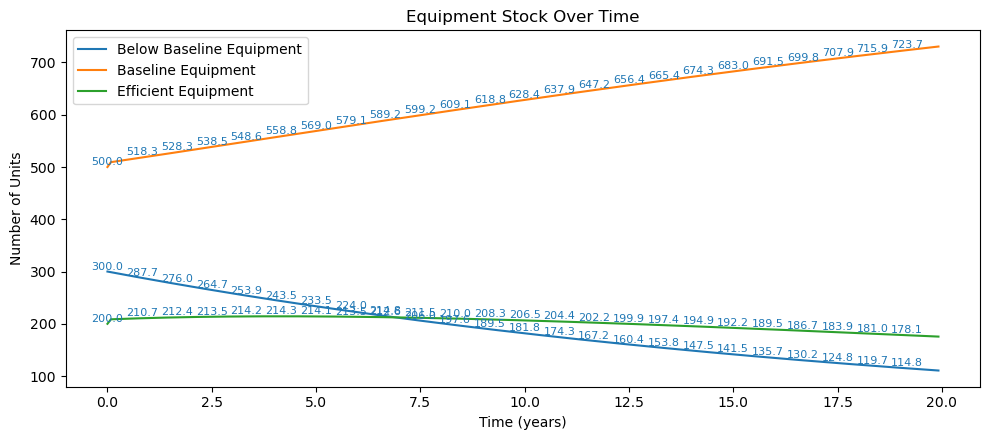

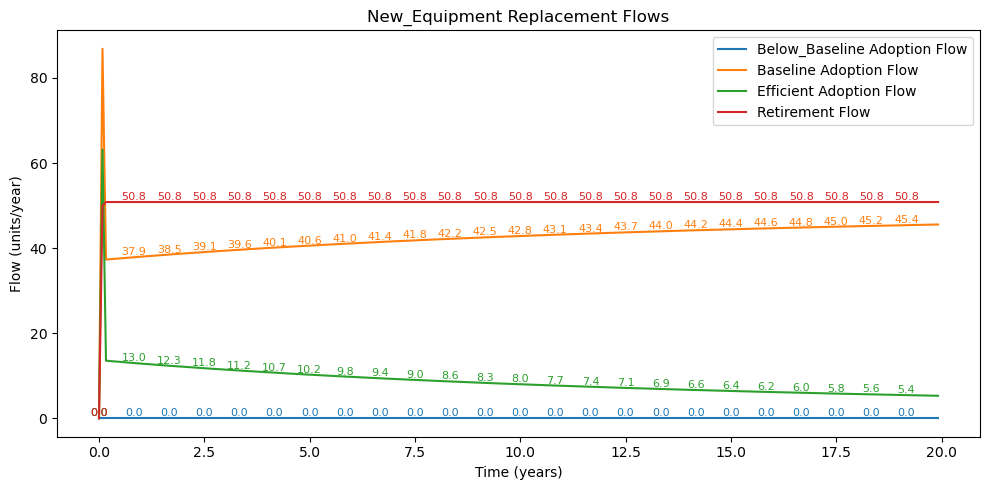

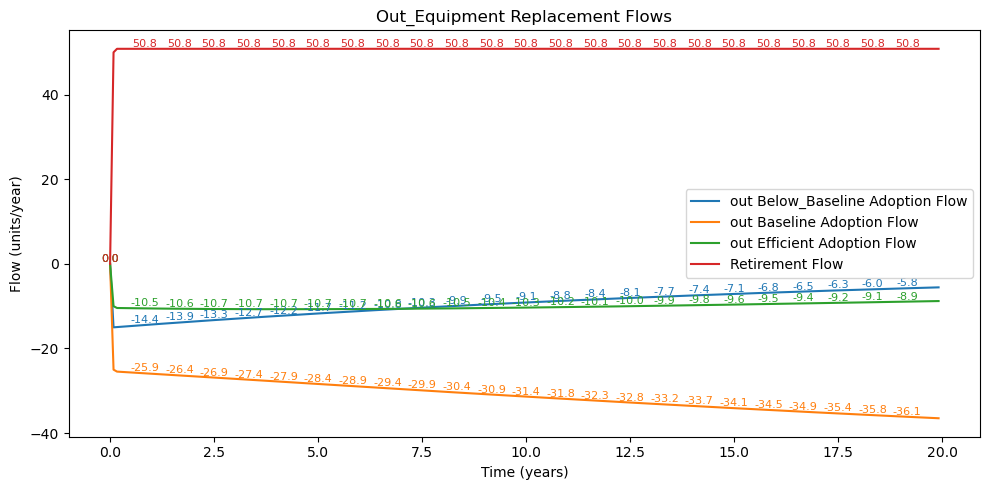

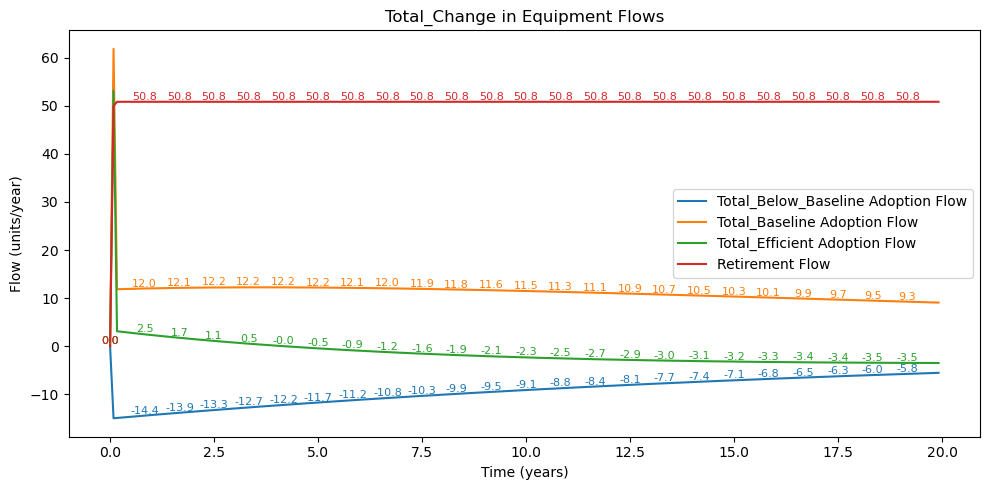

In [89]:
# Equipment Stocks
plt.figure(figsize=(10, 4.5))
plt.plot(time, Below_Baseline_Stock, label="Below Baseline Equipment")
plt.plot(time, Baseline_Stock, label="Baseline Equipment")
plt.plot(time, Efficient_Stock, label="Efficient Equipment")
for i in range(0, len(time), 10):
    plt.text(time[i], Efficient_Stock[i], f"{Efficient_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Baseline_Stock[i], f"{Baseline_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Below_Baseline_Stock[i], f"{Below_Baseline_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
plt.xlabel("Time (years)")
plt.ylabel("Number of Units")
plt.title("Equipment Stock Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# New Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, Below_Baseline_Adoption_Flow_arr, label="Below_Baseline Adoption Flow")
plt.plot(time, Baseline_Adoption_Flow_arr, label="Baseline Adoption Flow")
plt.plot(time, Efficient_Adoption_Flow_arr, label="Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], Below_Baseline_Adoption_Flow_arr[i], f"{Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Baseline_Adoption_Flow_arr[i], f"{Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], Efficient_Adoption_Flow_arr[i], f"{Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("New_Equipment Replacement Flows")
plt.legend()
plt.tight_layout()
plt.show()

# out Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, out_Below_Baseline_Adoption_Flow_arr, label="out Below_Baseline Adoption Flow")
plt.plot(time, out_Baseline_Adoption_Flow_arr, label="out Baseline Adoption Flow")
plt.plot(time, out_Efficient_Adoption_Flow_arr, label="out Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], out_Below_Baseline_Adoption_Flow_arr[i], f"{out_Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], out_Baseline_Adoption_Flow_arr[i], f"{out_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], out_Efficient_Adoption_Flow_arr[i], f"{out_Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Out_Equipment Replacement Flows")
plt.legend()
plt.tight_layout()
plt.show()

# Total Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, Total_Below_Baseline_Adoption_Flow_arr, label="Total_Below_Baseline Adoption Flow")
plt.plot(time, Total_Baseline_Adoption_Flow_arr, label="Total_Baseline Adoption Flow")
plt.plot(time, Total_Efficient_Adoption_Flow_arr, label="Total_Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], Total_Below_Baseline_Adoption_Flow_arr[i], f"{Total_Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Total_Baseline_Adoption_Flow_arr[i], f"{Total_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], Total_Efficient_Adoption_Flow_arr[i], f"{Total_Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Total_Change in Equipment Flows")
plt.legend()
plt.tight_layout()
plt.show()
